In [20]:
from skimage.io import imread
from skimage.filters import gaussian
import numpy as np
from matplotlib import pyplot as plt
from skimage import img_as_float
import scipy as sp

In [4]:
cov_target = imread('./data/target.jpg') # Returns R G B image

In [12]:
cov_target.shape

(240, 320, 3)

# Covariance Tracking

Compute C_model

In [2]:
modelCovMatrix = np.array([[47.917, 0, -146.636, -141.572, -123.269],
[0, 408.250, 68.487, 69.828, 53.479],
[-146.636, 68.487, 2654.285, 2621.672, 2440.381],
[-141.572, 69.828, 2621.672, 2597.818, 2435.368],
[-123.269, 53.479, 2440.381, 2435.368, 2404.923]])

Calc covariance for a given patch

In [89]:
def calc_cov(patch):
    feature_vec = np.zeros((5,patch.shape[0]*patch.shape[1]))
    for i in range(0, patch.shape[0]):
        for j in range(0, patch.shape[1]):
            feature_vec[:, (i*patch.shape[1] + j)] = np.array([i, j, patch[i, j, 0], patch[i, j, 1], patch[i, j, 2]])
    return np.cov(feature_vec, bias=True)

Calc Distance from the given model

In [31]:
def cal_distance(cov_model, cov_candidate):
    ew, ev = sp.linalg.eig(cov_model, cov_candidate)
    return np.sqrt((np.log(ew)**2).sum())

Scan All the patches

In [70]:
def scan_patches(image, patch_size):
    for i in range(0, image.shape[0], patch_size[0]-1):
        for j in range(0, image.shape[1], patch_size[1]-1):
            yield image[i:i+patch_size[0], j:j+patch_size[1]], (i, j)

Find patch with minimum distance

In [91]:
patches = scan_patches(cov_target, (70, 24))

minPos = (0,0)
minDist = float("inf")

for patch in patches:
    dist = cal_distance(modelCovMatrix, calc_cov(patch[0]))
    if dist < minDist:
        minPos = patch[1]
        minDist = dist

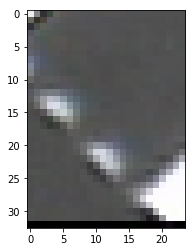

In [94]:
plt.imshow(cov_target[minPos[0]:minPos[0]+70, minPos[1]:minPos[1]+24])

# Mean-shift Tracking

## Create a function to extract a feature vector for each pixel in a circular neighborhood 

## Create a function to build a color histogram from a neighborhood of points

## Create a function to calculate a vector of the mean-shift weights

## use the functions above to perform mean-shift tracking